In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from variational import *
from normalizing_flow import *

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
N_TOT = mnist.train.images.shape[0]

# Since we use logit-normal model make sure
# 0. and 1. done't appear in images by adding/subtracting
# epsilon
mnist.train.images[mnist.train.images == 0.] += 0.001
mnist.train.images[mnist.train.images == 1.] -= 0.001

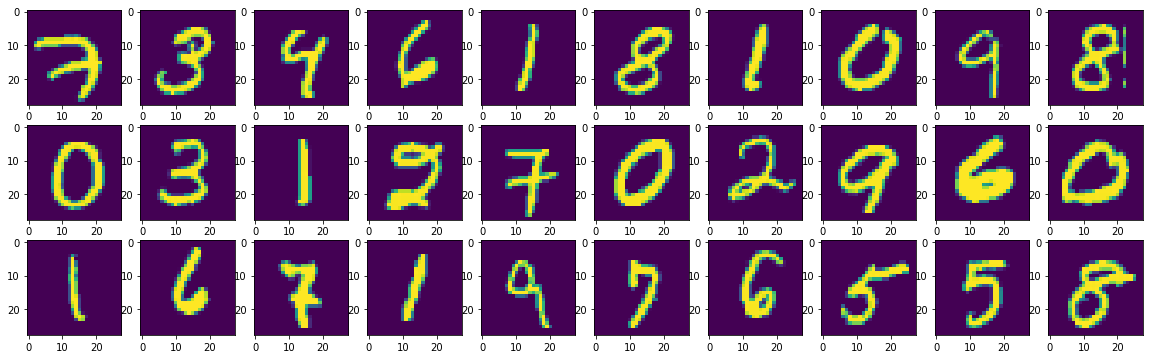

In [3]:
rows, cols = 3, 10
fig, ax = plt.subplots(rows, cols)
for i in range(rows * cols):
    ax[i // 10, i % 10].imshow(mnist.train.images[i, :].reshape([28, 28]))
fig.set_size_inches(2 * cols, 2 * rows)

In [4]:
def shuffled_batch_idx(n_examples, batch_size):
    shuffle_idx = np.random.choice(
        n_examples, n_examples, replace=False)
    rounded = n_examples - n_examples % batch_size
    shuffle_idx = shuffle_idx[:rounded]
    return list(shuffle_idx.reshape([rounded // batch_size, batch_size]))

# Model Parameters and Properties

We are setting up the variational auto-encoding Bayes from [AEVB](https://arxiv.org/pdf/1312.6114.pdf) paper. Where we have a stochastic decoder  $p_{\theta}(x|z)$ and a stochastic encoder $q_{\phi}(z|x)$ and the goal is to optimize the Evidence-Lower Bound (ELBO)

$\mathcal{L}(\theta, \phi; x) = \mathbb{E}_{q_{\phi}(z|x)}[\log p_{\theta}(x|z) + \log p_{\theta}(z)]
+ \mathcal{H}[q_{\phi}(z|x)] = \mathbb{E}_{q_{\phi}(z|x)}[\log p_{\theta}(x|z)]
- D_{KL}[q_{\phi}(z|x)||p_{\theta}(z)]$

In the following two blocks we set up these encoder/decoder using reparameterized Gaussian densities with diagonal covariance.

- $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), \sigma_{\theta}(z))$ where $\mu_{\theta}(.)$ and $\sigma_{\theta}(.)$ where are MLP functions
- $q_{\phi}(z|x) = \mathcal{N}(\mu_{\phi}(x), \sigma_{\phi}(x))$ where $\mu_{\phi}(.)$ and $\sigma_{\phi}(.)$ where are MLP functions

Also, using [normalizing flows](https://arxiv.org/pdf/1505.05770.pdf) we set up another stochastic encoder where $q(.|.)$ is a several layers of normalizing flows whose parameters are governed by MLP functions.

In the floowing blocks we set up the parameters and architecture of these neural network functions, and set up the flag `NORM_FLWO` to indicate which encoder we use.

In [5]:
#np.random.seed(85)

# Dimensionality of the latent space.
lat_dim = 10
# Dimensionality of observations space
# For MNIST is 28 x 28 images
obs_dim = 28 * 28

# Whether to use normalizing flows
NORM_FLOW = True

# Hidden units of the respective MLP functions
# Order in list corresponds to layer order
ENC_UNITS = [256, 128, lat_dim]
DEC_UNITS  = [128, 256, obs_dim]
# Number of normalizing flow layers
N_LAYER = 5

# Examples per batch for computing gradient
BATCH_EX = 1
# Number of samples for monte-carlo estimation
# of ELBO and its gradient
MC_EX = 5

In [7]:
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(dtype=tf.float64, shape=[BATCH_EX, obs_dim], name='input')
    if NORM_FLOW:
        encoder = FlowConditionalVariable(
            dim_x=lat_dim, y=x, flow_layers=N_LAYER, hidden_units=ENC_UNITS[:-1])
        z, log_q = encoder.sample_log_prob(n_samples=MC_EX)
        if BATCH_EX == 1:
            z = tf.expand_dims(z, axis=0)
            log_q = tf.expand_dims(log_q, axis=0)
        z = tf.transpose(z, [1, 0, 2])
        log_q = tf.transpose(log_q, [1, 0])
    else:
        # Standard reparametrized normal
        encoder = ReparameterizedDistribution(
            tf.distributions.Normal, MultiLayerPerceptron, input_tensor=x, layers=ENC_UNITS)
        z = encoder.sample(MC_EX)
        log_q = encoder.log_prob(z)

    # The decoder is a reparametrized logit_Normal because images [0., 1.]
    decoder = ReparameterizedDistribution(
            LogitNormal, MultiLayerPerceptron, input_tensor=z, layers=DEC_UNITS)
    x_hat = decoder.sample(1)
    # Prior distribution for codes.
    prior = tf.distributions.Normal(loc=np.zeros(lat_dim), scale=np.ones(lat_dim))

    # ELBO
    elbo = decoder.log_prob(x) + tf.reduce_mean(prior.log_prob(z), axis=-1) - log_q
    elbo = tf.reduce_mean(elbo, axis=0)

    # Choose the optimization algorithm to use
    train_op = tf.train.AdagradOptimizer(learning_rate=.01).minimize(- elbo)
    #train_op = tf.train.AdamOptimizer(learning_rate=.01).minimize(- elbo)

    my_sess = tf.Session()
    my_sess.run(tf.global_variables_initializer())

losses = []
TOT_ITERATIONS = 0
shuffle_idx = []

In [14]:
N_STEPS = 9 * 55000 # 15 full passes

with graph.as_default():
    for i in tqdm(range(N_STEPS)):
        if shuffle_idx == []:
            shuffle_idx = shuffled_batch_idx(N_TOT, BATCH_EX)
        idx = shuffle_idx.pop()
        observation = mnist.train.images[idx, :]
        _, elbo_value = my_sess.run(
            [train_op, elbo], feed_dict={'input:0': observation})
        losses.append(elbo_value)
        TOT_ITERATIONS += 1

100%|██████████| 495000/495000 [1:19:25<00:00, 103.88it/s]


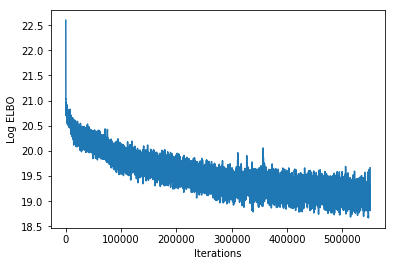

In [15]:
import scipy.signal

def mean_filt(x, window=100):
    return scipy.signal.resample(np.mean(np.reshape(
            x, [len(x) // window, window]), axis=1), len(x))
    
def filt(x, window=101):
    return scipy.signal.savgol_filter(x.ravel(), window, 3)

neg_log_elbo = np.log(-np.array(losses))

plt.plot(filt(neg_log_elbo))
plt.xlabel('Iterations')
plt.ylabel('Log ELBO')

plt.show()

# Latent Probabilistic Codes of Digits

In [16]:
recs = []
codes = []
i = 0
pbar = tqdm(total=N_TOT)
with graph.as_default():
    while i < N_TOT:
        pbar.update(BATCH_EX)
        observation = mnist.train.images[i:i+BATCH_EX, :]
        code_, rec_ = my_sess.run(
            [z, x_hat], feed_dict={'input:0': observation})
        if BATCH_EX == 1:
            recs.append(rec_)
            codes.append(code_)
        else:
            for j in range(rec_.shape[0]):
                recs.append(rec_[j, :, :])
                codes.append(code_[j, :, :])
        i += BATCH_EX

pbar.close()

100%|██████████| 55000/55000 [04:46<00:00, 191.85it/s]


In [17]:
codes1 = np.squeeze(np.array(codes)[:, 0, 0, :])
recs1 = np.squeeze(np.array(recs)[:, 0, 0, 0, :])
codes1.shape, recs1.shape

((55000, 10), (55000, 784))

# Codes and Reconstructions

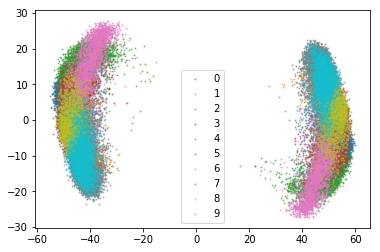

In [18]:
from  sklearn.decomposition import PCA
idx = []

codes = np.array(codes)

pca = PCA(n_components=2)
x_ = pca.fit_transform(np.squeeze(codes[:, 0, :]))

for i in range(10):
    idx.append(mnist.train.labels[:, i] == 1)

for i in range(10):
    plt.scatter(x_[idx[i], 0], x_[idx[i], 1], s=1, alpha=0.5)
#plt.xlim(-40, 40)
#plt.ylim(-20, 20)
plt.legend(range(0, 10))
plt.show()

# Samples from the Generative Model

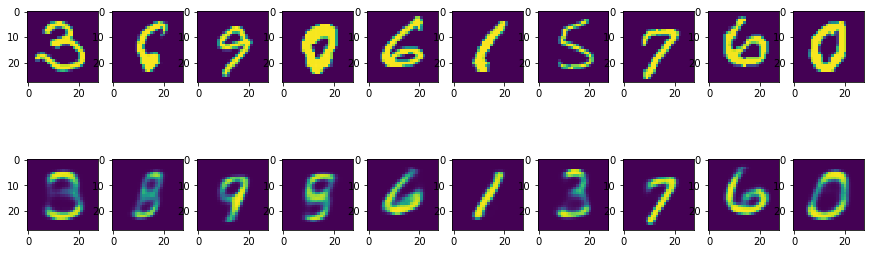

In [19]:
off_set = 12000
fig, ax = plt.subplots(2, 10)
for j in range(10):
    ax[0, j].imshow(np.reshape(mnist.train.images[off_set + j, :], [28, 28]), vmin=0, vmax=1)
    ax[1, j].imshow(np.reshape(recs1[off_set + j], [28, 28]), vmin=0, vmax=1)
fig.set_size_inches(15, 5)
plt.show()

In [20]:
my_sess.close()
